<a href="https://colab.research.google.com/github/Karan-Katiyar/Pytorch_Image_Classification_on_CIFAR/blob/main/PytorchCNNonCIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [6]:
# torch
import torch
import torch.nn    as nn
import torch.optim as optim

# torch utils
import torchvision
import torchvision.transforms as transforms

# additional libraries
import math
import numpy             as np
import matplotlib.pyplot as plt
# %matplotlib inline

# version check
# print(torch.__version__)

# Parameters

In [7]:
# data (general)
DATA_DIR          = './data'
DATA_NUM_CHANNELS = 3
DATA_NUM_CLASSES  = 10
DATA_CROP_ROWS    = 28
DATA_CROP_COLS    = 28

# data (for [-1, 1] or 0 mean 1 var normalization of CIFAR-10)
DATA_MEAN    = (0.5, 0.5, 0.5)
DATA_STD_DEV = (0.5, 0.5, 0.5)
# DATA_MEAN    = (0.49137914, 0.48213690, 0.44650456)
# DATA_STD_DEV = (0.24703294, 0.24348527, 0.26158544)

# data (loader)
DATA_BATCH_SIZE  = 32
DATA_NUM_WORKERS = 4

# data (for display)
DATA_CLASS_NAMES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# model
MODEL_LEVEL_0_BLOCKS   = 3
MODEL_LEVEL_1_BLOCKS   = 3
MODEL_LEVEL_2_BLOCKS   = 3
MODEL_LEVEL_0_CHANNELS = 32
MODEL_LEVEL_1_CHANNELS = 64
MODEL_LEVEL_2_CHANNELS = 128

# training (linear warm up with cosine decay learning rate)
TRAINING_LR_MAX          = 0.001
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 5
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 25
# TRAINING_LR_FINAL_EPOCHS = 2 # uncomment for a quick test
TRAINING_NUM_EPOCHS      = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT         = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL        = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# file
FILE_NAME = 'CifarCnn.pt'
FILE_SAVE = 0
FILE_LOAD = 0

# Data

In [8]:
# transforms for training and testing datasets
transform_train = transforms.Compose([transforms.RandomCrop((DATA_CROP_ROWS, DATA_CROP_COLS)), transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor(), transforms.Normalize(DATA_MEAN, DATA_STD_DEV)])
transform_test  = transforms.Compose([transforms.CenterCrop((DATA_CROP_ROWS, DATA_CROP_COLS)), transforms.ToTensor(), transforms.Normalize(DATA_MEAN, DATA_STD_DEV)])

# training and testing datasets with applied transform
dataset_train = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True,  download=True, transform=transform_train)
dataset_test  = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transform_test)

# training and testing datasets loader
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=DATA_BATCH_SIZE, shuffle=True,  num_workers=DATA_NUM_WORKERS, drop_last=True)
dataloader_test  = torch.utils.data.DataLoader(dataset_test,  batch_size=DATA_BATCH_SIZE, shuffle=False, num_workers=DATA_NUM_WORKERS, drop_last=True)

# debug - datasets
# print(dataset_train) # displays dataset info
# print(dataset_test)  # displays dataset info
# data_iterator_train = iter(dataloader_train)
# inputs, labels      = data_iterator_train.next()
# print(inputs.size())
# print(labels.size())
# data_iterator_test = iter(dataloader_test)
# inputs, labels     = data_iterator_test.next()
# print(inputs.size())
# print(labels.size())

# debug - stats computation
# torch.set_printoptions(precision=8)
# transform_stats     = transforms.Compose([transforms.ToTensor(), transforms.Normalize(DATA_MEAN, DATA_STD_DEV)])
# dataset_stats       = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transform_stats)
# dataloader_stats    = torch.utils.data.DataLoader(dataset_stats, batch_size=DATA_BATCH_SIZE, shuffle=False, num_workers=DATA_NUM_WORKERS, drop_last=True)
# num_batches         = 0
# data_mean           = torch.tensor([0.0, 0.0, 0.0])
# for data in dataloader_stats:
#     inputs, labels = data
#     data_mean      = data_mean + torch.mean(inputs, (0, 2, 3))
#     num_batches    = num_batches + 1
# data_mean = data_mean/(1.0*num_batches)
# data_mean = data_mean.reshape(1, 3, 1, 1)
# print(data_mean)
# num_batches = 0
# data_std    = torch.tensor([0.0, 0.0, 0.0])
# for data in dataloader_stats:
#     inputs, labels = data
#     data_std       = data_std + torch.mean((inputs - data_mean)*(inputs - data_mean), (0, 2, 3))
#     num_batches    = num_batches + 1
# data_std = data_std/(1.0*num_batches)
# data_std = torch.sqrt(data_std)
# data_std = data_std.reshape(1, 3, 1, 1)
# print(data_std)

Files already downloaded and verified
Files already downloaded and verified


# Network

In [9]:
# define
class Model(nn.Module):

    # initialization
    def __init__(self, data_num_channels, data_num_classes, model_level_0_blocks, model_level_1_blocks, model_level_2_blocks, model_level_0_channels, model_level_1_channels, model_level_2_channels):

        # parent initialization
        super(Model, self).__init__()

        # encoder level 0
        self.encoder0 = nn.ModuleList()
        self.encoder0.append(nn.Conv2d(data_num_channels, model_level_0_channels, (3, 3), stride=(1, 1), padding=(1, 1), dilation=(1, 1), groups=1, bias=False, padding_mode='zeros'))
        self.encoder0.append(nn.BatchNorm2d(model_level_0_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.encoder0.append(nn.ReLU())
        for n in range(model_level_0_blocks - 1):
            self.encoder0.append(nn.Conv2d(model_level_0_channels, model_level_0_channels, (3, 3), stride=(1, 1), padding=(1, 1), dilation=(1, 1), groups=1, bias=False, padding_mode='zeros'))
            self.encoder0.append(nn.BatchNorm2d(model_level_0_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
            self.encoder0.append(nn.ReLU())

        # encoder level 1
        self.encoder1 = nn.ModuleList()
        self.encoder1.append(nn.MaxPool2d((3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), return_indices=False, ceil_mode=False))
        self.encoder1.append(nn.Conv2d(model_level_0_channels, model_level_1_channels, (3, 3), stride=(1, 1), padding=(1, 1), dilation=(1, 1), groups=1, bias=False, padding_mode='zeros'))
        self.encoder1.append(nn.BatchNorm2d(model_level_1_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.encoder1.append(nn.ReLU())
        for n in range(model_level_1_blocks - 1):
            self.encoder1.append(nn.Conv2d(model_level_1_channels, model_level_1_channels, (3, 3), stride=(1, 1), padding=(1, 1), dilation=(1, 1), groups=1, bias=False, padding_mode='zeros'))
            self.encoder1.append(nn.BatchNorm2d(model_level_1_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
            self.encoder1.append(nn.ReLU())

        # encoder level 2
        self.encoder2 = nn.ModuleList()
        self.encoder2.append(nn.MaxPool2d((3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), return_indices=False, ceil_mode=False))
        self.encoder2.append(nn.Conv2d(model_level_1_channels, model_level_2_channels, (3, 3), stride=(1, 1), padding=(1, 1), dilation=(1, 1), groups=1, bias=False, padding_mode='zeros'))
        self.encoder2.append(nn.BatchNorm2d(model_level_2_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.encoder2.append(nn.ReLU())
        for n in range(model_level_2_blocks - 1):
            self.encoder2.append(nn.Conv2d(model_level_2_channels, model_level_2_channels, (3, 3), stride=(1, 1), padding=(1, 1), dilation=(1, 1), groups=1, bias=False, padding_mode='zeros'))
            self.encoder2.append(nn.BatchNorm2d(model_level_2_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
            self.encoder2.append(nn.ReLU())

        # decoder
        self.decoder = nn.ModuleList()
        self.decoder.append(nn.AdaptiveAvgPool2d((1, 1)))
        self.decoder.append(nn.Flatten())
        self.decoder.append(nn.Linear(model_level_2_channels, data_num_classes, bias=True))

    # forward path
    def forward(self, x):

        # encoder level 0
        for layer in self.encoder0:
            x = layer(x)

        # encoder level 1
        for layer in self.encoder1:
            x = layer(x)

        # encoder level 2
        for layer in self.encoder2:
            x = layer(x)

        # decoder
        for layer in self.decoder:
            x = layer(x)

        # return
        return x

# create
model = Model(DATA_NUM_CHANNELS, DATA_NUM_CLASSES, MODEL_LEVEL_0_BLOCKS, MODEL_LEVEL_1_BLOCKS, MODEL_LEVEL_2_BLOCKS, MODEL_LEVEL_0_CHANNELS, MODEL_LEVEL_1_CHANNELS, MODEL_LEVEL_2_CHANNELS)

# visualization
# print(model)

# ONNX export
# model_x = torch.randn(1, DATA_NUM_CHANNELS, DATA_CROP_ROWS, DATA_CROP_COLS, dtype=torch.float)
# torch.onnx.export(model, model_x, "CifarCnn.onnx", verbose=True)

# Train

In [10]:
# start epoch
start_epoch = 0

# learning rate schedule
def lr_schedule(epoch):

    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)*max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + TRAINING_LR_FINAL

    return lr

# error (softmax cross entropy)
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# specify the device as the GPU if present with fallback to the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# transfer the network to the device
model.to(device)

# model loading
if FILE_LOAD == 1:
    checkpoint = torch.load(FILE_NAME)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1

# cycle through the epochs
for epoch in range(start_epoch, TRAINING_NUM_EPOCHS):

    # initialize train set statistics
    model.train()
    training_loss = 0.0
    num_batches   = 0

    # set the learning rate for the epoch
    for g in optimizer.param_groups:
        g['lr'] = lr_schedule(epoch)

    # cycle through the train set
    for data in dataloader_train:

        # extract a batch of data and move it to the appropriate device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass, loss, backward pass and weight update
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # update statistics
        training_loss = training_loss + loss.item()
        num_batches   = num_batches + 1

    # initialize test set statistics
    model.eval()
    test_correct = 0
    test_total   = 0

    # no weight update / no gradient needed
    with torch.no_grad():

        # cycle through the test set
        for data in dataloader_test:

            # extract a batch of data and move it to the appropriate device
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward pass and prediction
            outputs      = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # update test set statistics
            test_total   = test_total + labels.size(0)
            test_correct = test_correct + (predicted == labels).sum().item()

    # epoch statistics
    print('Epoch {0:2d} lr = {1:8.6f} avg loss = {2:8.6f} accuracy = {3:5.2f}'.format(epoch, lr_schedule(epoch), (training_loss/num_batches)/DATA_BATCH_SIZE, (100.0*test_correct/test_total)))

# model saving
# to use this for checkpointing put this code block inside the training loop at the end (e.g., just indent it 4 spaces)
# and set 'epoch' to the current epoch instead of TRAINING_NUM_EPOCHS - 1; then if there's a crash it will be possible
# to load this checkpoint and restart training from the last complete epoch instead of having to start training at the
# beginning
if FILE_SAVE == 1:
    torch.save({
        'epoch': TRAINING_NUM_EPOCHS - 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, FILE_NAME)

Epoch  0 lr = 0.000010 avg loss = 0.056368 accuracy = 46.43
Epoch  1 lr = 0.000208 avg loss = 0.036812 accuracy = 65.89
Epoch  2 lr = 0.000406 avg loss = 0.027576 accuracy = 71.92
Epoch  3 lr = 0.000604 avg loss = 0.023901 accuracy = 76.25
Epoch  4 lr = 0.000802 avg loss = 0.021718 accuracy = 78.05
Epoch  5 lr = 0.001000 avg loss = 0.019990 accuracy = 79.63
Epoch  6 lr = 0.000998 avg loss = 0.017786 accuracy = 78.41
Epoch  7 lr = 0.000992 avg loss = 0.016272 accuracy = 81.76
Epoch  8 lr = 0.000981 avg loss = 0.014906 accuracy = 83.65
Epoch  9 lr = 0.000966 avg loss = 0.013814 accuracy = 84.62
Epoch 10 lr = 0.000947 avg loss = 0.012904 accuracy = 85.09
Epoch 11 lr = 0.000925 avg loss = 0.012168 accuracy = 85.76
Epoch 12 lr = 0.000898 avg loss = 0.011401 accuracy = 85.99
Epoch 13 lr = 0.000867 avg loss = 0.010860 accuracy = 86.30
Epoch 14 lr = 0.000833 avg loss = 0.009979 accuracy = 87.28
Epoch 15 lr = 0.000795 avg loss = 0.009601 accuracy = 87.62
Epoch 16 lr = 0.000754 avg loss = 0.0088

# Test

In [11]:
# initialize test set statistics
model.eval()
test_correct = 0
test_total   = 0

# initialize class statistics
class_correct = list(0. for i in range(DATA_NUM_CLASSES))
class_total   = list(0. for i in range(DATA_NUM_CLASSES))

# no weight update / no gradient needed
with torch.no_grad():

    # cycle through the test set
    for data in dataloader_test:

        # extract a batch of data and move it to the appropriate device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass and prediction
        outputs      = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # update test set statistics
        test_total   = test_total + labels.size(0)
        test_correct = test_correct + (predicted == labels).sum().item()

        # update class statistics
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label                 = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

# test set statistics
print('Accuracy of test set = {0:5.2f}'.format((100.0*test_correct/test_total)))
print('')

# class statistics
for i in range(DATA_NUM_CLASSES):
    print('Accuracy of {0:5s}    = {1:5.2f}'.format(DATA_CLASS_NAMES[i], (100.0*class_correct[i]/class_total[i])))

Accuracy of test set = 90.95

Accuracy of plane    = 92.99
Accuracy of car      = 96.20
Accuracy of bird     = 85.09
Accuracy of cat      = 82.15
Accuracy of deer     = 92.10
Accuracy of dog      = 84.85
Accuracy of frog     = 93.40
Accuracy of horse    = 94.48
Accuracy of ship     = 94.78
Accuracy of truck    = 93.40


# Display

Ground truth =    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog
Predicted    =    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog



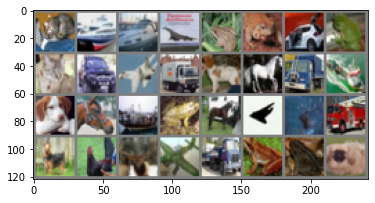

In [12]:
# set to evaluation mode
model.eval()

# extract a batch of data
data_iterator  = iter(dataloader_test)
inputs, labels = data_iterator.next()

# images and ground truth labels
images    = torchvision.utils.make_grid(inputs)/2 + 0.5
np_images = images.numpy()
plt.imshow(np.transpose(np_images, (1, 2, 0)))
print('Ground truth = ', ' '.join('%5s' % DATA_CLASS_NAMES[labels[j]] for j in range(DATA_BATCH_SIZE)))

# move it to the appropriate device
inputs, labels = inputs.to(device), labels.to(device)

# forward pass and prediction
outputs      = model(inputs)
_, predicted = torch.max(outputs, 1)

# predicted labels
print('Predicted    = ', ' '.join('%5s' % DATA_CLASS_NAMES[predicted[j]] for j in range(DATA_BATCH_SIZE)))
print('')